# Milestone 4: Leveraging Linguistic Insights to Unmask Fake Reviews

## Overview and Methodological Rational for Model Approach

In developing a model to detect fake reviews, one avenue we chose to explore was an approach that emphasizes statistical and qualitative linguistic features over deep learning-based natural language processing (NLP) transformers. This decision was based on several key considerations grounded in both practicality and literature on text analysis. In particular, M.L. Newman's 2003 paper "Lying words: Predicting deception from linguistic styles" identifies key linguistic cues that are often present in deceptive text. These cues include the use of fewer first-person pronouns, more negative emotion words, and fewer unique words.

1. Interpretability and Simplicity: One primary advantage of using simpler linguistic and statistical measures (such as word counts, parts of speech frequencies, and sentiment scores) is their interpretability. Models based on these features are often easier to understand and audit compared to models based on deep learning architectures. Literature suggests that interpretability is crucial in applications where understanding the decision-making process of the model is as important as the accuracy of the predictions. This transparency is especially important in the context of fake review detection, where stakeholders may need to understand why a review was flagged as fake.

2. Computational Efficiency: Models based on simpler statistical features are generally less computationally intensive compared to transformer-based models. This efficiency makes them more accessible for deployment in environments with limited computational resources. Futhermore, training time is considerably reduced, which is critical for rapid prototyping and model iteration.

3. Focused Feature Engineering: The use of linguistic features like POS tagging, unique word counts, and sentiment analysis allows for targeted feature engineering based on theoretical and empirical research linking these aspects to deceptive text. For instance, studies have shown that deceptive text often contains fewer unique words and relies more heavily on nouns and adjectives to create a believable but vague narrative (Newman). Similarly, sentiment extremes have been identified as potential indicators of fake reviews, aiming to overly praise or unduly criticize a product or service.

## Preprocessing and Feature Engineering

The preprocessing steps where taken care of in a previous milestone, where we cleaned the text data, removed stopwords, and tokenized the text. In this milestone, we focus on feature engineering to extract relevant statistical and  qualitative aspects of the text that are indicative of authenticity or deception. By focusing on elements such as sentiment analysis, unique word counts, and POS tagging, we align our methodology with literature findings that suggests these metrics can effectively distinguish genuine content from fake reviews.

**Feature Justification:**
- **Sentiment Analysis:** Sentiment analysis is a common feature used in fake review detection models. Fake reviews often exhibit extreme sentiment, either overly positive or negative, as a way to manipulate readers' perceptions. By calculating sentiment scores for each review, we can identify reviews with sentiment that deviates significantly from the norm.
- **Unique Word Count:** Fake reviews often contain fewer unique words compared to genuine reviews. This is because deceptive text tends to be more repetitive and less detailed. By counting the number of unique words in each review, we can capture this characteristic.
- **Parts of Speech (POS) Tagging:** POS tagging can provide insights into the syntactic structure of the text. Deceptive reviews may exhibit different POS patterns compared to genuine reviews. For example, fake reviews might contain more adjectives or nouns to create a positive or negative impression without providing substantive information. By analyzing the distribution of POS tags in the text, we can identify patterns that are indicative of deception.

## Modeling Strategy

The choice to utilize machine learning models like AdaBoost, Random Forest, and Logistic Regression was motivated by their interpretability, ease of implementation, and ability to handle a mix of numerical and categorical features. These models are well-suited for the linguistic features we have engineered, as they can capture complex relationships between the features and the target variable (fake vs. genuine reviews).

**Modeling with Selected Features:**
- **AdaBoost:** AdaBoost is an ensemble method that combines multiple weak learners to create a strong classifier. It is particularly effective when dealing with text data and can handle both numerical and categorical features. By using AdaBoost, we aim to leverage the power of boosting to improve the model's performance.
- **Random Forest:** Random Forest is an ensemble method that builds multiple decision trees and combines their predictions. It is robust to overfitting and can handle a mix of feature types. Random Forest is well-suited for our linguistic features as it can capture non-linear relationships between the features and the target variable.
- **Logistic Regression:** Logistic Regression is a linear model that is widely used for binary classification tasks. It is interpretable and can provide insights into the importance of each feature. By using Logistic Regression, we aim to understand the contribution of each linguistic feature to the model's predictions.

## Modeling Pipeline

The modeling pipeline involves several steps to prepare the data, engineer features, train the models, and evaluate their performance. The purpose is for easy reproducibility and scalability of the model development process. The process incorporates creating, fitting, and evaluating multiple machine learning models, using a structured pipeline approach to ensure systematic optimization and validation of model parameters. 

1. Pipeline Creation and Configuration: The `create_pipeline` function is essential for standardizing the modeling process. It takes an estimator (SKlearn machine learning model), a parameter grid for hyperparameter tuning, and a cross-validation strategy as inputs. TThe pipeline comprises of two main stages:
- Preprocessing with MinMaxScaler: This stage normalizes all the feature values to a range between 0 and 1. Normalization is crucial as it ensures that all feature contribute equally to the model's learning, preventing single feature with a larger scale from dominating the learning process.
- Hyperparameter Tuning with GridSearchCV: This component optimizes the model parameters using grid search, which systematically tests a range of user-specified parametr values to fund the combination that maximizes the model's performance, assessed via the ROC-AUC score. This ensures the robustness of the model by selecting the best parameters from a defined set.
2. Pipeline Fitting: The `fit_pipeline` function is designed to fit the pipeline to the training data. It executed the preprocessing and parameter tuning defined in the pipeline configuration. The process includes printing the status of the fitting, which is critical for debugging and tracking the progress of the model training, especially in scenarios involving extensive computational work.
3. Model Evaluation: Once the models are fitted, the `evaluate_models` function assesses their performance using cross-validation. This method provides a more robust estimate of model effectiveness by evaluating the model across multiple subsamples of the data. The evaluation metrics used are:
- Accuracy: Measures the overall correctness of the model.
- Precision: Assesses the model's accuracy in predicting positive labels.
- Recall: Evaluates how well the model can identify all positive instances/
- F1 Score: Provides a balance between precision and recall.

After training, the models are evaluated using the previously mentgioned metrics, and a summary of the results is provided for comparison. The Random Forest model is selected as the best-performing model based on the ROC-AUC score, which is a robust metric for evaluating binary classification models.

In [1]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import re
import seaborn as sns
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from textblob import TextBlob

nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/connorpoetzinger/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
def load_data(filepath="./data/processed/processed.csv"):
    return pd.read_csv(filepath)

In [3]:
def generate_sentiment_scores(df):
    sentiments = df["text_"].apply(lambda review: TextBlob(str(review)).sentiment)
    df["sentiment_score"], df["sentiment_subjectivity"] = zip(*sentiments)
    return df

In [4]:
def visualize_sentiment_scores(df):
    sns.histplot(df["sentiment_score"], kde=True)
    plt.title("Sentiment Score Distribution")
    plt.show()

    sentiment_categories = df["sentiment_score"].apply(
        lambda score: "Positive" if score >= 0 else "Negative"
    )
    sns.countplot(x=sentiment_categories)
    plt.title("Sentiment Score Distribution")
    plt.show()

In [5]:
def count_negative_words(df):
    df["neg_count"] = df["text_"].apply(
        lambda review: sum(
            TextBlob(word).sentiment.polarity < 0 for word in str(review).split()
        )
    )
    return df

In [6]:
def count_unique_words(df):
    df["word_count"] = df["text_"].apply(lambda x: len(str(x).split()))
    df = df[df["word_count"] != 0].reset_index(drop=True)
    df["unique_word_count"] = df["text_"].apply(lambda x: len(set(str(x).split())))
    return df

In [7]:
# pos tagging
articles = ["a", "an", "the"]
negations = [
    "not",
    "no",
    "never",
    "none",
    "nobody",
    "nothing",
    "neither",
    "nowhere",
    "nor",
]
auxiliaries = [
    "be",
    "have",
    "do",
    "will",
    "would",
    "shall",
    "should",
    "can",
    "could",
    "may",
    "might",
    "must",
]


def count_pos(review):
    filter = re.sub("[^\w\s]", "", str(review))
    review_lower = filter.lower()
    review_split = review_lower.split()

    unique_words = Counter(review_split)
    sentence = " ".join(unique_words.keys())

    word_list = nltk.word_tokenize(sentence)

    Art = sum(word in articles for word in word_list)
    Nega = sum(word in negations for word in word_list)
    Aux = sum(word in auxiliaries for word in word_list)

    tagged = nltk.pos_tag(word_list)
    counts = Counter(tag for word, tag in tagged)

    nount_count = sum(counts[i] for i in counts.keys() if "NN" in i)
    verb_count = sum(counts[i] for i in counts.keys() if "VB" in i)
    adj_count = sum(counts[i] for i in counts.keys() if "JJ" in i)
    adv_count = sum(counts[i] for i in counts.keys() if "RB" in i)
    pro_count = sum(
        counts[i]
        for i in counts.keys()
        if (("PRP" in i) or ("PRP$" in i) or ("WP" in i) or ("WP$" in i))
    )
    pre_count = sum(counts[i] for i in counts.keys() if "IN" in i)
    con_count = sum(counts[i] for i in counts.keys() if "CC" in i)

    return [
        nount_count,
        verb_count,
        adj_count,
        adv_count,
        pro_count,
        pre_count,
        con_count,
        Art,
        Nega,
        Aux,
    ]

In [8]:
def calculate_authenticity(df):
    df["authenticity"] = (
        df["pro_count"] + df["unique_word_count"] - df["neg_count"]
    ) / df["word_count"]
    return df

In [9]:
def calculate_analytical_thinking(df):
    df["analytical_thinking"] = (
        30
        + df[["art_count", "pre_count"]].sum(axis=1)
        - df[["pro_count", "con_count", "adv_count", "neg_count"]].sum(axis=1)
    )
    return df

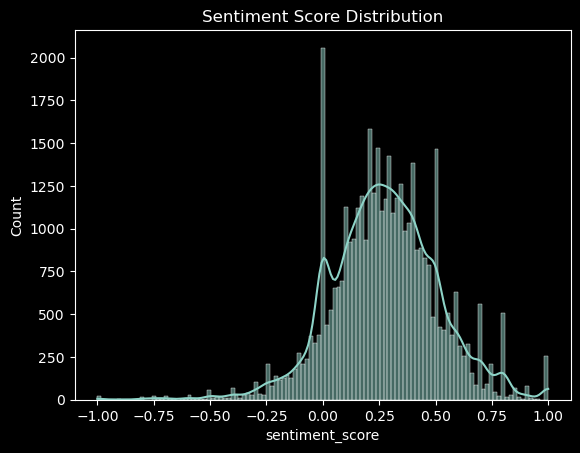

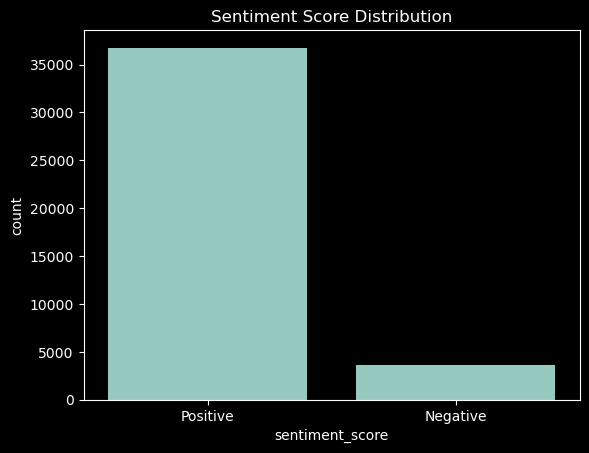

In [11]:
df = load_data()
df = generate_sentiment_scores(df)
visualize_sentiment_scores(df)
df = count_negative_words(df)
df = count_unique_words(df)
pos = [
    "noun_count",
    "verb_count",
    "adj_count",
    "adv_count",
    "pro_count",
    "pre_count",
    "con_count",
    "art_count",
    "neg_count",
    "aux_count",
]
df[pos] = (
    pd.DataFrame(df["text_"].apply(count_pos).tolist(), columns=pos)
    .fillna(0)
    .astype(int)
)
df = calculate_authenticity(df)
df = calculate_analytical_thinking(df)

In [13]:
def create_pipeline(estimator, param_grid, cv):
    pipeline = Pipeline(
        [
            ("preprocessing", MinMaxScaler()),
            (
                "classifier",
                GridSearchCV(
                    estimator=estimator,
                    param_grid=param_grid,
                    scoring="roc_auc",
                    cv=cv,
                    n_jobs=-1,
                    verbose=2,
                ),
            ),
        ]
    )
    return pipeline

In [14]:
def fit_pipeline(pipeline, X_train, y_train):
    print("Fitting grid search...")
    pipeline.fit(X_train, y_train)
    print("Grid search fitted.")
    return pipeline

In [15]:
def evaluate_models(models, X, y, folds):
    scoring = {
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score),
        "recall": make_scorer(recall_score),
        "f1_score": make_scorer(f1_score),
    }
    scores = {
        model_name: cross_validate(model, X, y, cv=folds, scoring=scoring)
        for model_name, model in models.items()
    }
    models_scores_table = pd.DataFrame(
        {
            model_name: [
                model_scores["test_accuracy"].mean(),
                model_scores["test_precision"].mean(),
                model_scores["test_recall"].mean(),
                model_scores["test_f1_score"].mean(),
            ]
            for model_name, model_scores in scores.items()
        },
        index=["Accuracy", "Precision", "Recall", "F1 Score"],
    )
    models_scores_table["Best Score"] = models_scores_table.idxmax(axis=1)
    return models_scores_table

In [16]:
df_model = df[
    [
        "rating",
        "sentiment_score",
        "sentiment_subjectivity",
        "word_count",
        "noun_count",
        "adj_count",
        "verb_count",
        "adv_count",
        "authenticity",
        "analytical_thinking",
        "score",
    ]
]

X = df_model
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
# Adaboost
DTC = DecisionTreeClassifier(random_state=11, class_weight="balanced", max_depth=None)
ABC = AdaBoostClassifier(estimator=DTC)
parameters = {
    "n_estimators": [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20],
    "learning_rate": [(0.97 + x / 100) for x in range(0, 8)],
    "algorithm": ["SAMME"],
}
pipeline1 = create_pipeline(ABC, parameters, 5)
pipeline1 = fit_pipeline(pipeline1, X_train, y_train)

# RandomForest
parameters = {
    "bootstrap": [True],
    "max_depth": [80, 90, 100, 110],
    "max_features": [2, 3, 4, 5, 6],
    "min_samples_leaf": [2, 3, 4],
    "min_samples_split": [2, 5, 10],
    "n_estimators": [100, 200, 300, 1000],
}
pipeline2 = create_pipeline(
    RandomForestClassifier(random_state=42), parameters, StratifiedKFold(n_splits=2)
)
pipeline2 = fit_pipeline(pipeline2, X_train, y_train)

# Logistic Regression
parameters = {
    "C": [10**i for i in range(-5, 5)],
    "class_weight": [None, "balanced"],
}
pipeline3 = create_pipeline(
    LogisticRegression(max_iter=1000), parameters, StratifiedKFold(n_splits=5)
)
pipeline3 = fit_pipeline(pipeline3, X_train, y_train)

models = {
    "AdaBoost": pipeline1,
    "Random Forest": pipeline2,
    "Logistic Regression": pipeline3,
}

models_scores_table = evaluate_models(models, X, y, 3)

Fitting grid search...
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[CV] END algorithm=SAMME, learning_rate=0.97, n_estimators=2; total time=   0.3s
[CV] END algorithm=SAMME, learning_rate=0.97, n_estimators=2; total time=   0.3s
[CV] END algorithm=SAMME, learning_rate=0.97, n_estimators=2; total time=   0.2s
[CV] END algorithm=SAMME, learning_rate=0.97, n_estimators=2; total time=   0.3s
[CV] END algorithm=SAMME, learning_rate=0.97, n_estimators=2; total time=   0.3s
[CV] END algorithm=SAMME, learning_rate=0.97, n_estimators=3; total time=   0.4s
[CV] END algorithm=SAMME, learning_rate=0.97, n_estimators=3; total time=   0.4s
[CV] END algorithm=SAMME, learning_rate=0.97, n_estimators=3; total time=   0.4s
[CV] END algorithm=SAMME, learning_rate=0.97, n_estimators=3; total time=   0.4s
[CV] END algorithm=SAMME, learning_rate=0.97, n_estimators=3; total time=   0.4s
[CV] END algorithm=SAMME, learning_rate=0.97, n_estimators=4; total time=   0.5s
[CV] END algorithm=SAMME, learning_rate=0.97, n_estimators=4; total time=   0.5s
[CV] END algorithm=SAMME, le

/Users/connorpoetzinger/miniforge3/envs/109b/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  13.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  12.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  13.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  12.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   3.5s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   3.7s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_sam

/Users/connorpoetzinger/miniforge3/envs/109b/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  10.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   9.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   9.8s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   9.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   2.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samp

/Users/connorpoetzinger/miniforge3/envs/109b/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   2.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  10.4s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   9.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   9.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   9.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_sam

/Users/connorpoetzinger/miniforge3/envs/109b/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   1.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  10.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   9.6s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   9.8s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=   9.1s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samp

In [18]:
models_scores_table

,AdaBoost,Random Forest,Logistic Regression,Best Score
Accuracy,0.676173,0.729522,0.699546,Random Forest
Precision,0.674298,0.723076,0.697613,Random Forest
Recall,0.682827,0.745005,0.704740,Random Forest
F1 Score,0.678407,0.733713,0.701151,Random Forest
